# **Text Summarization for Abstractive models.**

# Install necessory packages

In [84]:
!pip install torch
!pip install transformers
!pip install datasets
!pip install rouge
!pip install matplotlib
!pip install sentencepiece
!pip install rouge-score
!pip install nltk

# **Import all necessory Libraries**

In [85]:
import re
import string
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset
from rouge import Rouge
from rouge_score import rouge_scorer
import matplotlib.pyplot as plt
from transformers import BartTokenizer, BartForConditionalGeneration
from transformers import PegasusTokenizer, PegasusForConditionalGeneration
import concurrent.futures
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
from nltk.translate.meteor_score import meteor_score
import nltk

In [86]:
nltk.download('punkt')  # Download the Punkt tokenizer models

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# **Dataset-Reddit_tifu, long**

In [87]:
# Below code is to load the Reddit TIFU dataset using 'reddit_tifu' dataset ID
dataset = load_dataset('reddit_tifu', 'long')

# Below code is to get the 'documents' and 'tldr' columns from the dataset
data = {
    'text': dataset['train']['documents'],
    'summary': dataset['train']['tldr'],
}

# **Data preprocessing**

In [88]:
# Below code is to clean the data (remove irrelevant characters, punctuation, etc.)
def clean_text(text):
    # Remove links, special characters, and extra spaces
    text = re.sub(r'http\S+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = " ".join(text.split())
    return text.lower()

# Below code is to apply the clean_text function to the 'text' and 'summary' columns
data['cleaned_text'] = [clean_text(text) for text in data['text']]
data['cleaned_summary'] = [clean_text(summary) for summary in data['summary']]

subset_size = 100
data_subset = {
    'text': data['cleaned_text'][:subset_size],
    'summary': data['cleaned_summary'][:subset_size],
}

# **BART:**

**Tokenizer**

In [89]:
# Tokenizer:
# Below Logic is to initialize BART tokenizer and creating pretrained model
tokenizer = BartTokenizer.from_pretrained("facebook/bart-large-cnn")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-large-cnn")

# Algorithm

In [90]:
# Below code is to function to compute bleu
def compute_bleu(reference, hypothesis):
    return sentence_bleu([reference], hypothesis)

# Below code is to function to process data in smaller batches
def process_batch(batch):
    batch_inputs = tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt')
    batch_labels = tokenizer(batch['summary'], padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        batch_outputs = model.generate(input_ids=batch_inputs['input_ids'], attention_mask=batch_inputs['attention_mask'])
    generated_summaries = tokenizer.batch_decode(batch_outputs, skip_special_tokens=True)
    return generated_summaries, batch_labels['input_ids']

# Below code is to generate summaries and compute ROUGE scores for the smaller subset
batch_size = 1
num_batches = (len(data_subset['text']) + batch_size - 1) // batch_size

rouge = Rouge()
scores = {'rouge-1': [], 'rouge-2': [], 'rouge-l': [], 'bleu': [], 'meteor': []}

# Below code is to iterate over the subset of the dataset and compute ROUGE, BLEU results
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(data_subset['text']))
    batch_data = {
        'text': data_subset['text'][start_idx:end_idx],
        'summary': data_subset['summary'][start_idx:end_idx]
    }
    gen_summaries, ref_summaries = process_batch(batch_data)
    for gen_summary, ref_summary in zip(gen_summaries, ref_summaries):
        decoded_ref_summary = tokenizer.decode(ref_summary, skip_special_tokens=True)

        rouge_scores = rouge.get_scores(gen_summary, decoded_ref_summary)[0]
        scores['rouge-1'].append(rouge_scores['rouge-1']['f'])
        scores['rouge-2'].append(rouge_scores['rouge-2']['f'])
        scores['rouge-l'].append(rouge_scores['rouge-l']['f'])

# Below code is to calculate BLEU score
        bleu_score = compute_bleu(decoded_ref_summary, gen_summary)
        scores['bleu'].append(bleu_score)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (142) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


# Scores

In [91]:
# Below code is to print Rouge scores
print("Rouge-1 scores batch wise ",scores['rouge-1'])
print("Rouge-2 scores batch wise ",scores['rouge-2'])
print("Rouge-L scores batch wise ",scores['rouge-l'])
print("BLEU scores batch wise",scores['bleu'])
print("BLEU Score is", bleu_score)

Rouge-1 scores batch wise  [0.14893616711634228, 0.1702127629945677, 0.09090908833792477, 0.06557376898683152, 0.13861385899813747, 0.21951219213265916, 0.2077922042098162, 0.21052631146814413, 0.153846149962565, 0.20779220516107272, 0.21621621239956174, 0.04999999781250009, 0.28235293812041523, 0.2898550686074355, 0.3235294080147059, 0.24999999538580253, 0.3999999961633218, 0.28260869322542537, 0.31847133257982074, 0.08791208562250942, 0.09677419206555671, 0.28124999559082037, 0.10909090686942154, 0.16981131746529018, 0.30303029951790633, 0.12307692091834321, 0.25490195616109196, 0.3519999957683201, 0.2278480969395931, 0.24242423944903582, 0.10309278118397283, 0.07766990085399195, 0.09090908739669434, 0.18487394616481895, 0.07692307488165685, 0.06349206021667944, 0.05769230424741145, 0.07792207462978594, 0.2558139490968091, 0.2417582372660307, 0.31884057536651966, 0.06779660807813855, 0.1481481458916324, 0.25263157435124656, 0.21917807821354857, 0.06896551486325811, 0.2812499957031251

In [92]:
# Below code is to print Rouge scores with Recall, Precision and F1 score.
rouge_1_recall = rouge_scores['rouge-1']['r']
rouge_1_precision = rouge_scores['rouge-1']['p']
rouge_1_f1_score = rouge_scores['rouge-1']['f']

print(f'ROUGE-1 -- Recall: {rouge_1_recall}, Precision: {rouge_1_precision}, F1-Score: {rouge_1_f1_score}')

rouge_2_recall = rouge_scores['rouge-2']['r']
rouge_2_precision = rouge_scores['rouge-2']['p']
rouge_2_f1_score = rouge_scores['rouge-2']['f']

print(f'ROUGE-2 -- Recall: {rouge_2_recall}, Precision: {rouge_2_precision}, F1-Score: {rouge_2_f1_score}')

rouge_l_recall = rouge_scores['rouge-l']['r']
rouge_l_precision = rouge_scores['rouge-l']['p']
rouge_l_f1_score = rouge_scores['rouge-l']['f']

print(f'ROUGE-L -- Recall: {rouge_l_recall}, Precision: {rouge_l_precision}, F1-Score: {rouge_l_f1_score}')

ROUGE-1 -- Recall: 0.2857142857142857, Precision: 0.02127659574468085, F1-Score: 0.039603959105970046
ROUGE-2 -- Recall: 0.0, Precision: 0.0, F1-Score: 0.0
ROUGE-L -- Recall: 0.2857142857142857, Precision: 0.02127659574468085, F1-Score: 0.039603959105970046


In [93]:
# Below code is to print average Rouge scores
average_rouge1 = sum(score for score in scores['rouge-1']) / len(scores['rouge-1'])
average_rouge2 = sum(score for score in scores['rouge-2']) / len(scores['rouge-2'])
average_rougeL = sum(score for score in scores['rouge-l']) / len(scores['rouge-l'])
average_bleu = sum(score for score in scores['bleu']) / len(scores['bleu'])

print("Average ROUGE-1: {:.4f}".format(average_rouge1))
print("Average ROUGE-2: {:.4f}".format(average_rouge2))
print("Average ROUGE-L: {:.4f}".format(average_rougeL))
print("Average BLEU: {:.4f}".format(average_bleu))

Average ROUGE-1: 0.1779
Average ROUGE-2: 0.0266
Average ROUGE-L: 0.1392
Average BLEU: 0.1380


# Graphs

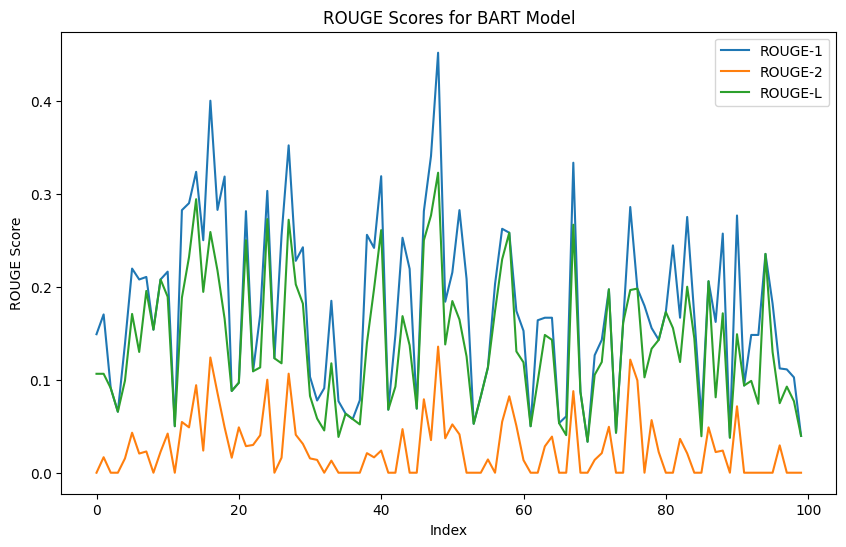

In [94]:
# Below code is plot the ROUGE scores
plt.figure(figsize=(10, 6))
plt.plot(scores['rouge-1'], label='ROUGE-1')
plt.plot(scores['rouge-2'], label='ROUGE-2')
plt.plot(scores['rouge-l'], label='ROUGE-L')
plt.xlabel('Index')
plt.ylabel('ROUGE Score')
plt.legend()
plt.title('ROUGE Scores for BART Model')
plt.show()


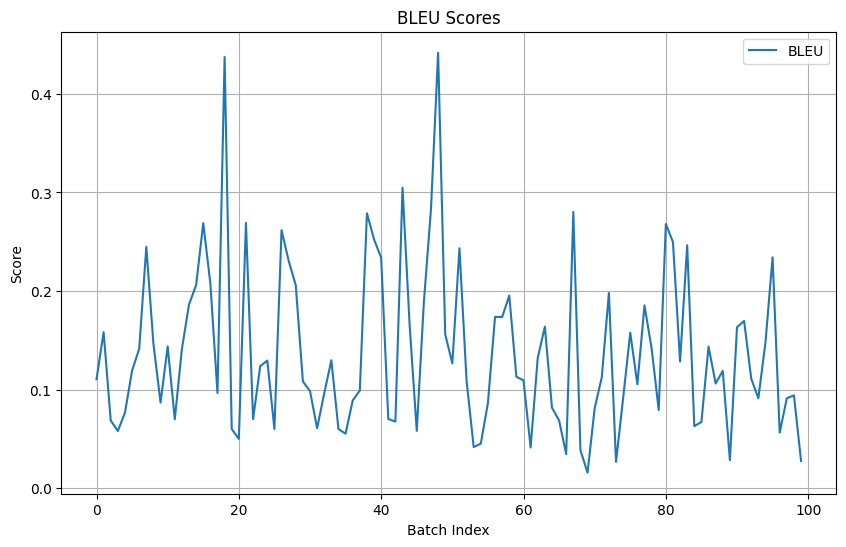

In [95]:
# Below code is to Plot BLEU scores
plt.figure(figsize=(10, 6))
plt.plot(scores['bleu'], label='BLEU')
plt.xlabel('Batch Index')
plt.ylabel('Score')
plt.title('BLEU Scores for BART')
plt.legend()
plt.grid()
plt.show()

# **T5**

In [96]:
# Below code is to initialize T5 tokenizer and model
t5_tokenizer = T5Tokenizer.from_pretrained("t5-small")
model_t5 = T5ForConditionalGeneration.from_pretrained("t5-small")

In [97]:
# Below code is function to process data in smaller batches
def process_batch1(batch):
    batch_inputs = t5_tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt')
    batch_labels = t5_tokenizer(batch['summary'], padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        batch_outputs = model_t5.generate(input_ids=batch_inputs['input_ids'], attention_mask=batch_inputs['attention_mask'])
    generated_summaries = t5_tokenizer.batch_decode(batch_outputs, skip_special_tokens=True)
    return generated_summaries, batch_labels['input_ids']

# Below code is to generate summaries and compute ROUGE scores for the smaller subset
batch_size = 1
num_batches = (len(data_subset['text']) + batch_size - 1) // batch_size

rouge = Rouge()
scores1 = {'rouge-1': [], 'rouge-2': [], 'rouge-l': [], 'bleu': []}

# Below code is to iterate over the subset of the dataset and compute ROUGE, BLEU, and METEOR results
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(data_subset['text']))
    batch_data = {
        'text': data_subset['text'][start_idx:end_idx],
        'summary': data_subset['summary'][start_idx:end_idx]
    }
    gen_summaries, ref_summaries = process_batch1(batch_data)
    for gen_summary, ref_summary in zip(gen_summaries, ref_summaries):
        decoded_ref_summary = t5_tokenizer.decode(ref_summary, skip_special_tokens=True)

        rouge_scores1 = rouge.get_scores(gen_summary, decoded_ref_summary)[0]
        scores1['rouge-1'].append(rouge_scores1['rouge-1']['f'])
        scores1['rouge-2'].append(rouge_scores1['rouge-2']['f'])
        scores1['rouge-l'].append(rouge_scores1['rouge-l']['f'])

# Below code is to calculate BLEU score
        bleu_score1 = compute_bleu(decoded_ref_summary, gen_summary)
        scores1['bleu'].append(bleu_score1)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()


# Scores:

In [98]:
# Below code is to print Rouge scores
print("Rouge-1 scores batch wise ",scores1['rouge-1'])
print("Rouge-2 scores batch wise ",scores1['rouge-2'])
print("Rouge-L scores batch wise ",scores1['rouge-l'])
print("BLEU scores batch wise",scores1['bleu'])
print("BLEU Score is", bleu_score1)

Rouge-1 scores batch wise  [0.14814814370370383, 0.07142856665816359, 0.07999999520000028, 0.11111110709876558, 0.19999999502222232, 0.2962962913580247, 0.2758620642568371, 0.07407407061728412, 0.11428570997551038, 0.24999999500000009, 0.1428571384948981, 0.0, 0.24999999500000009, 0.12499999507812519, 0.3225806402081166, 0.15789473252077574, 0.39999999533061226, 0.3703703653772291, 0.08988763845474061, 0.2142857093877552, 0.3999999955555556, 0.12121211658402223, 0.0, 0.16666666191358037, 0.06451612403746138, 0.21052631091412755, 0.2692307651257397, 0.19230768837278112, 0.22222221797839511, 0.14814814370370383, 0.36363635880165296, 0.0, 0.0, 0.14634145877453913, 0.0, 0.14814814315500704, 0.06249999595703151, 0.19354838210197725, 0.19999999580000008, 0.21276595295608883, 0.12903225394380866, 0.11111110635802489, 0.08333332847222251, 0.26086956136105866, 0.13793103020214045, 0.1481481432098767, 0.05882352456747445, 0.32653060816326535, 0.2307692270192308, 0.3684210476869806, 0.36363635880

In [99]:
# Below code is to print Rouge scores with Recall, Precision and F1 score.
rouge_1_recall = rouge_scores1['rouge-1']['r']
rouge_1_precision = rouge_scores1['rouge-1']['p']
rouge_1_f1_score = rouge_scores1['rouge-1']['f']

print(f'ROUGE-1 -- Recall: {rouge_1_recall}, Precision: {rouge_1_precision}, F1-Score: {rouge_1_f1_score}')

rouge_2_recall = rouge_scores1['rouge-2']['r']
rouge_2_precision = rouge_scores1['rouge-2']['p']
rouge_2_f1_score = rouge_scores1['rouge-2']['f']

print(f'ROUGE-2 -- Recall: {rouge_2_recall}, Precision: {rouge_2_precision}, F1-Score: {rouge_2_f1_score}')

rouge_l_recall = rouge_scores1['rouge-l']['r']
rouge_l_precision = rouge_scores1['rouge-l']['p']
rouge_l_f1_score = rouge_scores1['rouge-l']['f']

print(f'ROUGE-L -- Recall: {rouge_l_recall}, Precision: {rouge_l_precision}, F1-Score: {rouge_l_f1_score}')

ROUGE-1 -- Recall: 0.14285714285714285, Precision: 0.3333333333333333, F1-Score: 0.19999999580000008
ROUGE-2 -- Recall: 0.0, Precision: 0.0, F1-Score: 0.0
ROUGE-L -- Recall: 0.14285714285714285, Precision: 0.3333333333333333, F1-Score: 0.19999999580000008


# Graph

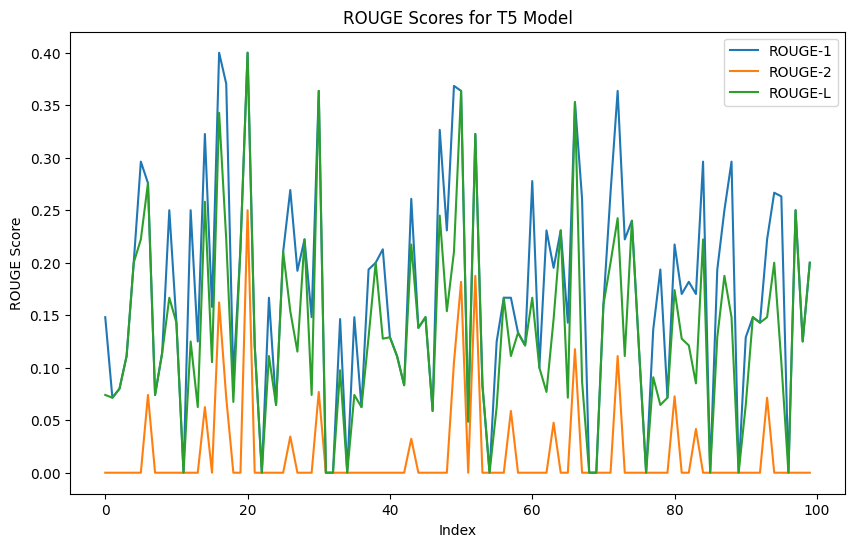

In [100]:
# Below code is to plot the ROUGE scores
plt.figure(figsize=(10, 6))
plt.plot(scores1['rouge-1'], label='ROUGE-1')
plt.plot(scores1['rouge-2'], label='ROUGE-2')
plt.plot(scores1['rouge-l'], label='ROUGE-L')
plt.xlabel('Index')
plt.ylabel('ROUGE Score')
plt.legend()
plt.title('ROUGE Scores for T5 Model')
plt.show()

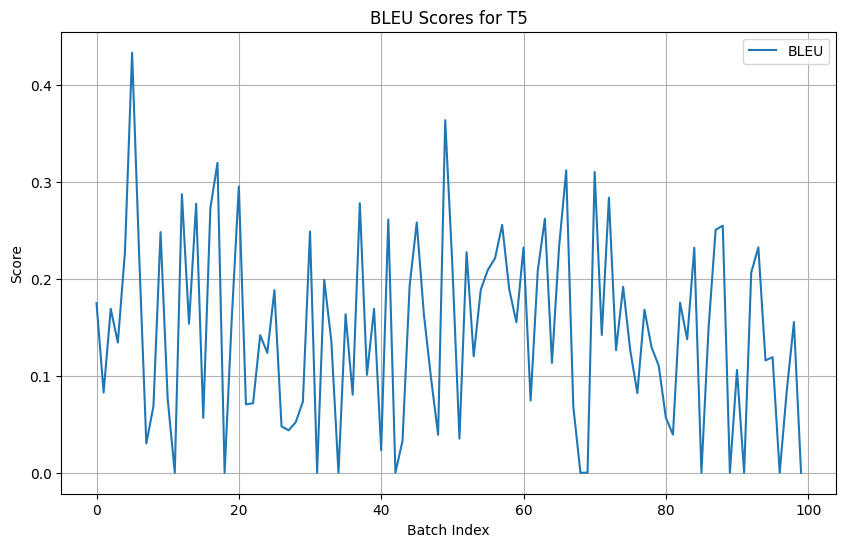

In [101]:
# Below code is to plot BLEU scores
plt.figure(figsize=(10, 6))
plt.plot(scores1['bleu'], label='BLEU')
plt.xlabel('Batch Index')
plt.ylabel('Score')
plt.title('BLEU Scores for T5')
plt.legend()
plt.grid()
plt.show()

# **Pegasus:**

## Tokenizer:

In [102]:
# Below code is to initialize Pegasus tokenizer and model
pegasus_tokenizer = PegasusTokenizer.from_pretrained("google/pegasus-xsum")
model_pegasus = PegasusForConditionalGeneration.from_pretrained("google/pegasus-xsum")

Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at google/pegasus-xsum and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Algorithm

In [103]:
# Below code is to process data in smaller batches
def process_batch2(batch):
    batch_inputs = pegasus_tokenizer(batch['text'], padding=True, truncation=True, return_tensors='pt')
    batch_labels = pegasus_tokenizer(batch['summary'], padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        batch_outputs = model_pegasus.generate(input_ids=batch_inputs['input_ids'], attention_mask=batch_inputs['attention_mask'])
    generated_summaries = pegasus_tokenizer.batch_decode(batch_outputs, skip_special_tokens=True)
    return generated_summaries, batch_labels['input_ids']

# Below code is to generate summaries and compute ROUGE and BLEU scores for the smaller subset
batch_size = 1
num_batches = (len(data_subset['text']) + batch_size - 1) // batch_size

rouge = Rouge()
scores2 = {'rouge-1': [], 'rouge-2': [], 'rouge-l': [], 'bleu': []}

# Below code is to iterate over the subset of the dataset and compute ROUGE, BLEU results
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(data_subset['text']))
    batch_data = {
        'text': data_subset['text'][start_idx:end_idx],
        'summary': data_subset['summary'][start_idx:end_idx]
    }
    gen_summaries, ref_summaries = process_batch2(batch_data)
    for gen_summary, ref_summary in zip(gen_summaries, ref_summaries):
        decoded_ref_summary = pegasus_tokenizer.decode(ref_summary, skip_special_tokens=True)

        rouge_scores2 = rouge.get_scores(gen_summary, decoded_ref_summary)[0]
        scores2['rouge-1'].append(rouge_scores2['rouge-1']['f'])
        scores2['rouge-2'].append(rouge_scores2['rouge-2']['f'])
        scores2['rouge-l'].append(rouge_scores2['rouge-l']['f'])

# Below code is to calculate BLEU score
        bleu_score2 = sentence_bleu([decoded_ref_summary.split()], gen_summary.split())
        scores2['bleu'].append(bleu_score2)

# Below code is to tokenize reference and hypothesis using nltk
        tokenized_ref_summary = nltk.word_tokenize(decoded_ref_summary)
        tokenized_gen_summary = nltk.word_tokenize(gen_summary)


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1369: UserWarning: Using `max_length`'s default (64) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


# Scores:

In [104]:
# Below code is to print Rouge scores
print("Rouge-1 scores batch wise ",scores2['rouge-1'])
print("Rouge-2 scores batch wise ",scores2['rouge-2'])
print("Rouge-L scores batch wise ",scores2['rouge-l'])
print("BLEU scores batch wise",scores2['bleu'])
print("BLEU Score is", bleu_score2)

Rouge-1 scores batch wise  [0.11940298114502129, 0.26315788979224386, 0.15999999520000013, 0.10526315401662063, 0.0, 0.08333332864583361, 0.31578946869806096, 0.23333332913333338, 0.16216215760409072, 0.2666666634666667, 0.2608695603686201, 0.1538461491124262, 0.2941176420761246, 0.0, 0.20689654687277062, 0.127659569524672, 0.05882352484429102, 0.29629629264060364, 0.11881187778060984, 0.07692307195266304, 0.12499999736328131, 0.0888888839111114, 0.07407407023319637, 0.2777777730246914, 0.12903225306971924, 0.0, 0.2592592549451304, 0.16949152083883953, 0.38095237613378696, 0.060606055647383326, 0.08333332836805586, 0.1481481432098767, 0.0, 0.09756097096966114, 0.19047618557823143, 0.18181817698347122, 0.09999999511250024, 0.12903225306971924, 0.3142857094857143, 0.10810810539079627, 0.06249999570312531, 0.3333333285802469, 0.2857142807142858, 0.042553187487551304, 0.2857142808163266, 0.0, 0.07407407023319637, 0.38461538021449704, 0.11999999656800012, 0.21052631084487544, 0.285714281044

In [106]:
# Below code is to print Average Rouge scores.
average_rouge1 = sum(score for score in scores2['rouge-1']) / len(scores2['rouge-1'])
average_rouge2 = sum(score for score in scores2['rouge-2']) / len(scores2['rouge-2'])
average_rougeL = sum(score for score in scores2['rouge-l']) / len(scores2['rouge-l'])
average_bleu = sum(score for score in scores2['bleu']) / len(scores2['bleu'])

print("Average ROUGE-1: {:.4f}".format(average_rouge1))
print("Average ROUGE-2: {:.4f}".format(average_rouge2))
print("Average ROUGE-L: {:.4f}".format(average_rougeL))
print("Average BLEU: {:.4f}".format(average_bleu))

Average ROUGE-1: 0.1536
Average ROUGE-2: 0.0232
Average ROUGE-L: 0.1205
Average BLEU: 0.0031


# Graphs:

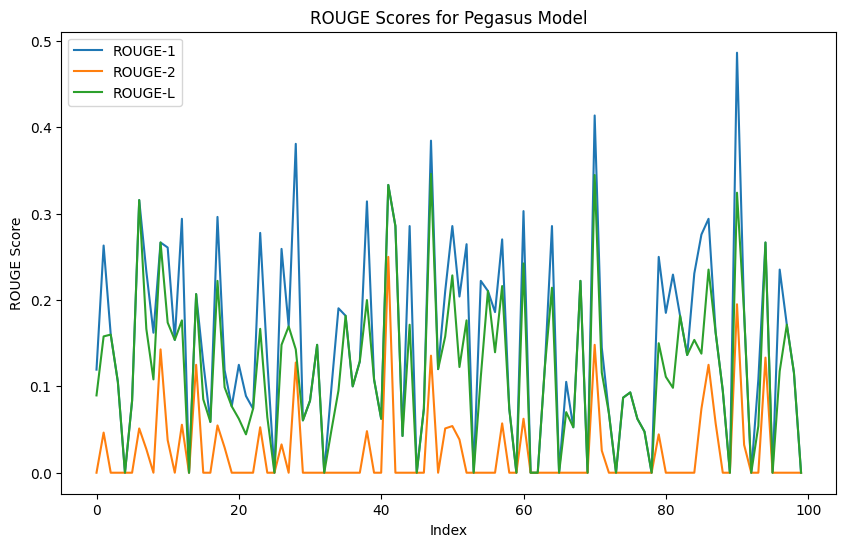

In [107]:
# Below code is to plot the ROUGE scores
plt.figure(figsize=(10, 6))
plt.plot(scores2['rouge-1'], label='ROUGE-1')
plt.plot(scores2['rouge-2'], label='ROUGE-2')
plt.plot(scores2['rouge-l'], label='ROUGE-L')
plt.xlabel('Index')
plt.ylabel('ROUGE Score')
plt.legend()
plt.title('ROUGE Scores for Pegasus Model')
plt.show()


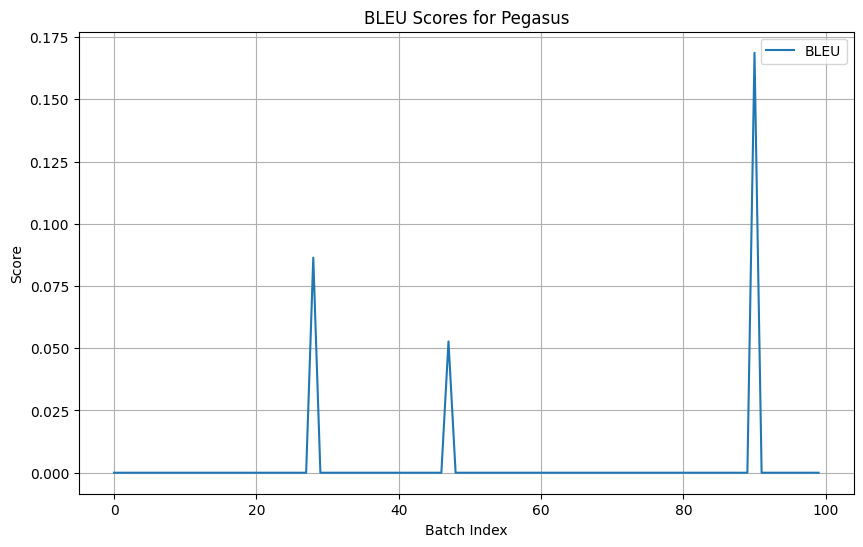

In [108]:
# Below code is to plot BLEU scores
plt.figure(figsize=(10, 6))
plt.plot(scores2['bleu'], label='BLEU')
plt.xlabel('Batch Index')
plt.ylabel('Score')
plt.title('BLEU Scores for Pegasus')
plt.legend()
plt.grid()
plt.show()